# Data Analysis in Geoscience Remote Sensing Projects: Exercises - 3
## Regression analysis and sensitivity estimation
Hendrik Andersen, contact: hendrik.andersen@kit.edu 

Let's import the fremont data again as toy data for the regression example.

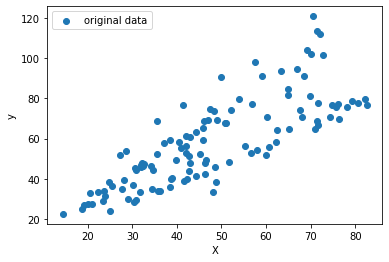

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Read in data as pandas dataframe
df = pd.read_csv('Fremont.csv', index_col='Date', parse_dates=True)
df = df.rename(columns={"Fremont Bridge Total": "total", 
                        "Fremont Bridge East Sidewalk": "east",
                        "Fremont Bridge West Sidewalk": "west"}) 

X = df['east'].resample('m').mean()
y = df['west'].resample('m').mean()
z = df['total'].resample('m').mean()
plt.scatter(X, y, label='original data')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.show()

### Different packages for regression
There are different packages available that allow the computation of a simple (multiple) linear regression. The standard module is probably stats in the scipy package. This contains the function linregress().

In [2]:
# Using the linregress() function from the scipy.stats module to calculate a regression line
from scipy import stats

# the function linregress() returns the slope intercept, r_value, p_value, and std_err of a regression. 
# you can write your code like this  
slope, intercept, rvalue, pvalue, stderr = stats.linregress(X,y)
# or like this
results = stats.linregress(X,y)
# and then access e.g. the slope like so:
results.pvalue

3.332561036521629e-27

You can then plot the regression line simply by using the regression formula as the y in the plt.plot() function

$Y = \beta_0 + \beta_1 * X$

where $\beta_0$ is the intercept and $\beta_1$ the slope

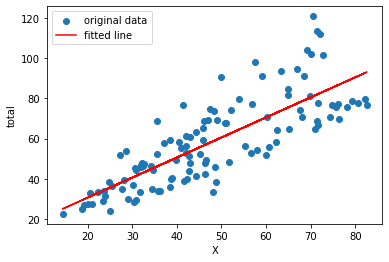

In [3]:
# Plot the resulting line above a scatterplot to visualize the result
plt.scatter(X,y, label='original data')
plt.plot(X, intercept + slope*X, 'r', label='fitted line')
plt.legend()
plt.xlabel('X')
plt.ylabel('total')
plt.legend()
plt.show()

Another useful package one can use to compute a linear regression is scikit-learn or short sklearn. Sklearn is one of the most popular machine learning packages in python. 

In [4]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()

# to use the function LinearRegression() from sklearn, the X data needs to have a 2-dimensional shape
X_ = np.expand_dims(X, axis = 1)
print(X.shape, X_.shape)

(116,) (116, 1)


Sklearn is designed so that all statistical and machine learning models can be called with the same methods (e.g. .fit(), or .predict() - see the help or the sklearn website: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) and will work with the same data structures. This is also the reason why the function LinearRegression() expects a 2-dimensional array, as the standard input data to machine learning models has multiple predictors and is structured as an n x p dimensional array, with n the number of observations and p the number of predictors. This comes in handy later when we just conveniently change the model used by changing only one line of code... 

[]

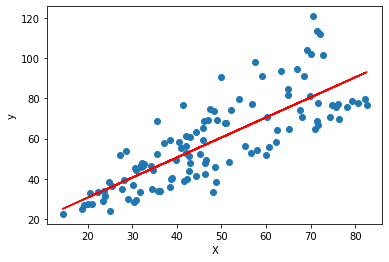

In [5]:
# fit the regression
regr.fit(X_,y)
# use the trained linear model to predict a value for each of the 116 observations in X_
y_pred = regr.predict(X_)

fig, ax = plt.subplots()
ax.scatter(X, y, label='original data')
# you can plot the regression line by using the predicted values (just plot it as a line and not as scattered points)
ax.plot(X, y_pred, color='r', label='fitted line')
ax.set_ylabel('y')
ax.set_xlabel('X')
plt.plot()

### How good is the regression model?

To estimate the quality of the fit of the regression model, we need to quantify the $\epsilon$ of the linear regression equation and derive statistics from it

$Y = \beta_0 + \beta_1 * X + \epsilon$

We can first visualize the $\epsilon$, be drawing vertical lines (vlines) from the prediction to the observation

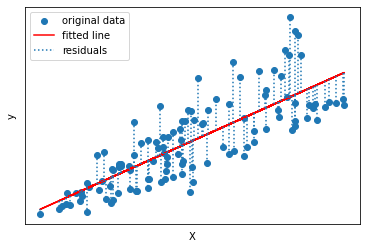

In [6]:
fig, ax = plt.subplots()
ax.scatter(X, y, label='original data')
ax.plot(X, y_pred, color='r', label='fitted line')
ax.set_ylabel('y')
ax.set_xlabel('X')
ax.vlines(X_,y_pred,y_pred+(y-y_pred), linestyle=':', label='residuals')
ax.legend()
ax.set_xticks(())
ax.set_yticks(())
plt.show()

Tasks:
1. Compute the RSS (residual sum of squares) and RSE (residual standard error) for the regression model
2. Create a residual plot to analyse the residuals. Are there any issues with the data?
3. Interpret the p-value: Can we reject the 0-hypothesis that there is no relationship between X and y? 
4. Compute the R$^2$ statistic: How much (%) of the variation in y is explained by X?

### Sensitivity estimation
The slope of the regression line is also called "regression coefficient" and can be understood as a sensitivity of y to a change in X 

In [7]:
# note that the derived coefficients of the two different solutions are not identical (but only because they are stored with different accuracy). 
# The function isclose() from the package math confirms that this.
print(slope)
print(regr.coef_)
print(slope==regr.coef_)

import math
print(math.isclose(slope,regr.coef_))

0.9993111831546323
[0.99931118]
[False]
True


Often, we need to calculate uncertainty estimates for the sensitivity estimate. We can do this, by calculating a range of values that contains the *true* sensitivity to a certain probability (typically 95%).

In [8]:
res = stats.linregress(X,y)

# here, we define a function that returns the confidence interval for the slope and the intercept 
def conf_int(X, model, p = 0.05):
    """
    This function calculates a confidence interval for a slope and intercept of a linear model.
    Only works when the model provided is a scipy.stats.linregress() model.
    Returns: confidence interval for a slope and intercept 
    """
    from scipy.stats import t
    ts = abs(t.ppf(p/2, len(X)-2))
    slope_ci = model.stderr*ts
    intercept_ci = model.intercept_stderr*ts
    return slope_ci, intercept_ci

# we can now call the function
slope_ci, intercept_ci = conf_int(X, res)
print(f"slope (95%): {res.slope:.6f} +/- {slope_ci:.2f}")
print(f"intercept (95%): {res.intercept:.6f}" f" +/- {intercept_ci:.2f}")

slope (95%): 0.999311 +/- 0.14
intercept (95%): 10.587960 +/- 7.05


To illustrate how data selection influences the estimated slope, let's split the data into two groups, and fit a model to each group

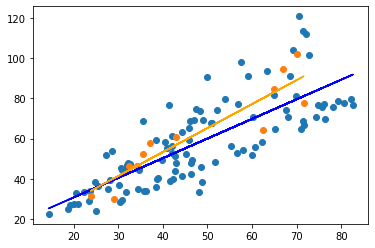

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.1, random_state=1) # the random_state argument creates pseudo (reproducable) random data 
regr.fit(X_train,y_train)
y_pred_train = regr.predict(X_train)
regr.fit(X_test,y_test)

y_pred_test = regr.predict(X_test)

plt.scatter(X_train,y_train, label='training data')
plt.scatter(X_test,y_test, label='test data')
plt.plot(X_train, y_pred_train, color='b', label='fitted line to training')
plt.plot(X_test, y_pred_test, color='orange', label='fitted line to test')
plt.show()

As we can see, the regression model that is fit to only a small number of data points can deviate substantially from the line that is fit to all data points. Takeaway: In real world problems, we never have *all* data points available. As such, the confidence interval gives us an important estimate of the range of likely values based on the data at hand. (by the way: confidence intervals are not only useful/important for estimating a regression slope, but also for estimating e.g. the mean value of a data set). A good scientific analysis will always provide both: an estimation and an uncertainty calculation.

Let's create random data for the same function that is shown in the slides to dive a bit deeper. 

$y = 2 + 3*X + \epsilon$

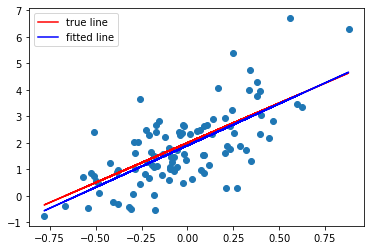

In [36]:
X = np.random.normal(0,0.1,100)*3
e = np.random.randn(100)
y = 2 + 3*X + e
slope, intercept, rvalue, pvalue, stderr = stats.linregress(X,y)

plt.scatter(X,y)
plt.plot(X, 2 + 3*X, 'r', label='true line')
plt.plot(X, intercept + slope*X, 'b', label='fitted line')
plt.legend()
plt.show()

Let's now do the same repeatedly for 1000 times (n_iter) and see what happens to the estimated sensitivities.   

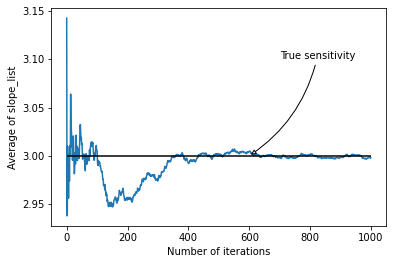

In [37]:
n_iter = 1000
slope_list = [] # we create empty lists into which we can add the results of each iteration  
intercept_list = []
mean_slopes = []
for i in range(n_iter):
    # create random data for each iteration
    X = np.random.normal(0,0.1,100)*3
    e = np.random.randn(100)
    y = 2 + 3*X + e
    # estimate regression for each iteration and add to lists
    slope, intercept, r_value, p_value, std_err = stats.linregress(X,y)
    slope_list.append(slope)
    intercept_list.append(intercept)
    # calculate the average of all slopes in the list at the time of this iteration 
    mean_slopes.append(np.mean(slope_list))

fig, ax = plt.subplots()
ax.plot(np.arange(n_iter),mean_slopes)   
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Average of slope_list')
ax.hlines(3,0,n_iter,color='k')
ax.annotate("True sensitivity", xy=(600, 3), xycoords='data', xytext=(700, 3.1), textcoords='data',
                  arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.2", fc="w"),)
plt.show()
# see tasks below 

We can also approximate the confidence intervals manually, by using such iterative approach, and using the percentiles of the distribution of all resultant slopes/intercepts. However, this is only illustrative...

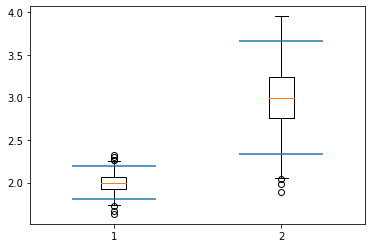

In [47]:
plt.boxplot([intercept_list,slope_list])
plt.hlines(np.percentile(intercept_list,2.5),0.75,1.25)
plt.hlines(np.percentile(intercept_list,97.5),0.75,1.25)
plt.hlines(np.percentile(slope_list,2.5),1.75,2.25)
plt.hlines(np.percentile(slope_list,97.5),1.75,2.25)
plt.show()

Let's take a look at the effects of outliers and high-leverage points for sensitivity estimates. 

In [48]:
# create copies of the data sets
y_outlier = y.copy()
X_outlier = X.copy()
y_leverage = y.copy()
X_leverage = X.copy()

# Change the first data point in the X and y data sets to create an outlier and a high-leverage point 
y_outlier[0] = -5
X_outlier[0] = 0
y_leverage[0] = -5
X_leverage[0] = 2

Tasks:
1. Compute a confidence interval for the two groups of data split with train_test_split. What is the reason for the differences in the range of the confidence interval?
2. Calculate a regression analysis for the outlier and high-leverage data and create a plot. Which of the issues (outlier/leverage) is more critical for sensitivity estimation?
3. Why is the line of the average slope_list approaching the true sensitivity?

### Multiple regression

For multiple regression, we use the LinearRegression() function from scipy. We first combine all predictor variables in an n x p shaped matrix 


In [49]:
# let's use X (eastward going cyclists), z (total cyclists), and a randomly generated dummy variable  

X = df['east'].resample('m').mean()
y = df['west'].resample('m').mean()
z = df['total'].resample('m').mean()

X_multi = np.array([X, z, np.random.randn(X.size)]).T
print(X_multi.shape)

(116, 3)


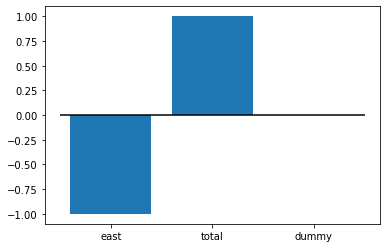

In [50]:
regr.fit(X_multi,y)
plt.bar(np.arange(3), height = regr.coef_)
plt.hlines(0,-0.5,2.5, color='k')
plt.xticks([0,1,2], labels = ['east','total','dummy'])
plt.show()

Tasks:
1. How do you interpret the negative and positive coefficients for 'east' and 'total' of the multiple regression? What could cause such strange behaviour when clearly both predictors should be positively related to the response?

### Data distributions, trends, stationarity
In linear regression, assumptions are made about the distribution of the date (normal distribution) to estimate p-values, coefficients and their uncertainties. Also, in environmental sciences stationarity (trends) and other temporal patterns (seasonal cycles) need to be accounted for. 

First, let us create a Pandas dataframe with randomly generated time series data.

In [ ]:
from datetime import datetime, timedelta
from scipy.stats import pearsonr

n = 365
date_today = datetime.now()
days = pd.date_range(date_today, date_today + timedelta(n-1), freq='D')

np.random.seed(seed=1)
x = np.random.randn(n) # x and y are normally distributed random numbers
y = np.random.randn(n)
not_normal = np.random.rand(n) # uniform distribution

x.size
df = pd.DataFrame({'time': days, 'x': x})
df['y'] = y
df['not_normal'] = not_normal
df = df.set_index('time')
df['lognorm'] = np.random.lognormal(size=n)
df.index = pd.to_datetime(df.index)
print(df)

In [ ]:
plt.scatter(df['x'],df['lognorm'])
plt.show()

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('Different distributions')
axs[0].hist(df['x'])
axs[1].hist(df['not_normal'])
plt.show()

The next figure shows some of the typical properties of normal distribution, which is not given in the uniform distribution. In a normal distribution, the mean = median (also the case for uniform), but also

1. 67% of the data is within 1 standard deviation of the mean
2. 95% of the data is within 2 standard deviations of the mean
2. 99.7% of the data is within 3 standard deviations of the mean

This is critical to estimate probabilities from data, a classic task for parameteric statistics (e.g. pearson correlation, linear regression). If normality is not given, the data should be transformed (see below), or a different statistical method be chosen (e.g. spearman correlation, which correlates the ranks of the data and not its values). The red vertical lines in the following show 1, 2, and 3 standard deviations from the mean, illustrating that the probability properties described above only hold for the normal distribution.

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('Different distributions')
axs[0].hist(x,bins=25)
axs[0].axvline(np.mean(df['x'])-np.std(df['x']),c='r')
axs[0].axvline(np.mean(df['x'])+np.std(df['x']),c='r')
axs[0].axvline(np.mean(df['x'])-2*np.std(df['x']),c='r',linestyle='--')
axs[0].axvline(np.mean(df['x'])+2*np.std(df['x']),c='r',linestyle='--')
axs[0].axvline(np.mean(df['x'])-3*np.std(df['x']),c='r',linestyle=':')
axs[0].axvline(np.mean(df['x'])+3*np.std(df['x']),c='r',linestyle=':')
axs[1].hist(not_normal,bins=25)
axs[1].axvline(np.mean(df['not_normal'])-np.std(df['not_normal']),c='r')
axs[1].axvline(np.mean(df['not_normal'])+np.std(df['not_normal']),c='r')
axs[1].axvline(np.mean(df['not_normal'])-2*np.std(df['not_normal']),c='r',linestyle='--')
axs[1].axvline(np.mean(df['not_normal'])+2*np.std(df['not_normal']),c='r',linestyle='--')
axs[1].axvline(np.mean(df['not_normal'])-3*np.std(df['not_normal']),c='r',linestyle=':')
axs[1].axvline(np.mean(df['not_normal'])+3*np.std(df['not_normal']),c='r',linestyle=':')
plt.show()

Here, data is randomly generated from a log distribution (see upper figure), but then transformed to approximate a normal distribution (lower panel). This is a typical step of data preprocessing.

In [ ]:
df['lognorm'] = np.random.lognormal(size=n)

plt.hist(df['lognorm'],bins=25)
plt.show()
# we can log-transform the data to give its distribution normality
plt.hist(np.log(df['lognorm']),bins=25)
plt.show()

The essence is: Before computing a correlation or regression, one should check for normality. There are a number of analyses/tests that can be done to achieve this.

1. Look at the histogram (should be bell-shaped)
2. Check if mean is close to median
3. Check how much of the data is within 1,2,3 standard deviations of the mean
4. Perform statistical test for normality

For the latter point, there are a variety of statistical tests that can be done, one of which is shown below. Please check the help to understand what the test does and how to interpret the outcome. Also, there are many online resources to find more information on this topic, e.g. https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

In [ ]:
# Test normality with Shapiro-Wilks Test
from scipy.stats import shapiro
print(shapiro(df['x'])) # Check out the help to find out what the test does
print(shapiro(df['lognorm']))
print(shapiro(np.log(df['lognorm'])))

In [ ]:
from scipy.stats import shapiro
help(shapiro)

### Trends in data
The following cells will visualize and help you understand how trends can change the statistical relationship, and hence the interpretation of the physical relationship between a predictor (x) and a predictand (y). We will work with the random time series data again.

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('Correlation coefficent: ' + str(round(pearsonr(df['x'],df['y'])[0],3))) # the data is not correlated, it is just random!
axs[0].plot(df['x'])
axs[1].plot(df['y'])
plt.show()

In [ ]:
plt.scatter(df['x'],df['y']) # the scatter plot also shows that there is no relationship between x and y

Clearly, there is no relationship between the two randomly generated data sets. Now, we are adding artificial trends to the random data.

In [ ]:
trend_1 = np.linspace(0,4,n)
trend_2 = np.linspace(-2,6,n)

df['x'] = df['x']+trend_1
df['y'] = df['y']+trend_2

fig, axs = plt.subplots(2)
fig.suptitle('Correlation coefficent: ' + str(round(pearsonr(df['x'],df['y'])[0],3)))
axs[0].plot(df['x'])
axs[1].plot(df['y'])
plt.show()

In [ ]:
plt.scatter(df['x'],df['y']) 
plt.show()

From the visualizations above, it now seems clear that the data is strongly correlated and that x has a strong impact on y - but it is just random data + trend! Trends in geoscientific data are not necessarily related, data therefore needs to be detrended. Any influence of x on y would be still visible in the residuals of the detrended data.

In [ ]:
from scipy import signal

df['x'] = signal.detrend(df['x'])
df['y'] = signal.detrend(df['y'])

fig, axs = plt.subplots(2)
fig.suptitle('Correlation coefficent: ' + str(round(pearsonr(df['x'],df['y'])[0],3)))
axs[0].plot(df['x'])
axs[1].plot(df['y'])
plt.show()

Similar aspects are relevant for seasonal cycles as well. In most cases, it is better to deseasonalize geoscientific data (e.g. by subtracting a running mean or the monthly mean).